In [1]:
"""
CII_VID_Forecast_Notebook.py

Ready-to-run Python notebook-like script to:
 - build a Schechter LF
 - map L -> voxel intensity
 - compute single-source PDF p1(I)
 - compute compound-Poisson VID via FFT
 - convolve with instrumental noise
 - bin into intensity bins and compute expected voxel counts
 - compute a Fisher forecast for Schechter parameters

Usage: open this file in the canvas/code editor, run cells (or execute as a script).
Dependencies: numpy, scipy, matplotlib

Notes:
 - This is a minimal, pedagogical template. Replace fiducial parameters and survey specs
   with realistic values for a real forecast. Add map-level MC and clustering corrections
   if you need greater realism.

"""

from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.interpolate import interp1d
from scipy.special import gamma
import copy
from astropy import units as u
import utils2 as ut
import numpy as np
import matplotlib.pyplot as plt
import E_lines as lines
#import props2 as p
import props_SpaceTIM as p
import EuclidProps as Eu
from importlib import reload

In [2]:
reload (p)
reload (Eu)

<module 'EuclidProps' from 'c:\\Users\\juzz\\Desktop\\TIM\\LIMxJuzz\\LIM\\TIMxGal\\EuclidProps.py'>

In [62]:


# -----------------------------
# 1) Schechter LF and utility functions
# -----------------------------

def schechter_L(L, phi_star, L_star, alpha):
    """Schechter luminosity function: phi(L) per unit L.

    Parameters
    ----------
    L : array
        Luminosity grid (same units as L_star)
    phi_star, L_star, alpha : floats
        Schechter parameters

    Returns
    -------
    phi : array
        phi(L) (units: number per volume per unit L)
    """
    return phi_star * (L / L_star)**alpha * np.exp(-L / L_star) / L_star

def double_schecter_L(L, phi_star, L_star, alpha, beta):
    """
    Double power-law luminosity function (Hemmati et al. 2018, Eq. 7):
        Phi(L) = phi_star / [ (L/L_star)^alpha + (L/L_star)^beta ]

    Parameters
    ----------
    L : array
        Luminosity grid (same units as L_star)
    phi_star : float
        Normalization (number per volume per unit L)
    L_star : float
        Characteristic luminosity
    alpha : float
        Faint-end slope
    beta : float
        Bright-end slope

    Returns
    -------
    phi : array
        Phi(L) (units: number per volume per unit L)
    """
    x = L / L_star
    return phi_star / (x**alpha + x**beta)

# -----------------------------
# 2) Map L -> voxel intensity
# -----------------------------

def L_to_I(L, z, delta_nu, conv_mode='I_nu'):
    """Map luminosity L -> voxel intensity
    Parameters
    ----------
    L : array
    z : float
    delta_nu : float (Hz)

    Returns
    -------
    I : array
    """
    # --- TODO: replace with proper cosmological conversion ---
    # placeholder conversion factor (units such that I ~ conv * L)
    conv = 1e-3
    #return conv * L
    return L / (4 * np.pi * (ut.luminosity_distance(z))**2) / delta_nu

# -----------------------------
# 3) Build single-galaxy intensity PDF p1(I)
# -----------------------------

def build_p1_I(Lgrid, phi_L, V_vox, Imin, Imax, nI):
    """Construct single-galaxy PDF p1(I) on a linear range of I.

    p1(I) = (V_vox * phi(L)) / Nbar * |dL/dI|
    but we construct the expected counts contribution per I-bin then normalize.
    """
    # map L -> I (this function assumes Lgrid already mapped externally if needed)
    Igrid_fromL = Lgrid.copy()  # user will pass Lgrid already converted to I units

    Ireg = np.linspace(Imin, Imax, nI)
    dI = (Ireg[1] - Ireg[0]) 

# --- Ensure units are consistent if using astropy units ---
    if hasattr(Igrid_fromL, 'unit'):
        #print("Using astropy units...")
        Ireg = Ireg * Igrid_fromL.unit
        dI = dI * Igrid_fromL.unit
        Imin = Imin * Igrid_fromL.unit

    #p1_counts = np.zeros_like(Ireg)
    p1_counts = np.zeros(Ireg.shape) # ensure no units for now. TODO: fix units properly later

    # bin contributions from Lgrid -> Ireg
    # Lgrid elements have implicit dL; approximate by differences
    dL = np.diff(Lgrid)
    dL = np.append(dL, dL[-1])

    for Li, phiLi, dl in zip(Igrid_fromL, phi_L, dL):
        # Li now represents intensity value (I = conv*L) if Lgrid was pre-converted
        #this makes the units wonky if using astropy units
        #TODO: I think phili needs to have units of number/volume/intensity
        # 
        idx = int(np.clip((Li - Imin) // dI, 0, len(Ireg)-1))
        num = ((V_vox * phiLi) * dl).value
        #print(f"V_vox, {V_vox}, phiLi, {phiLi}, dl, {dl}, num, {num}")
        p1_counts[idx] += num #TODO: stopgap. fix units

    Nbar = np.sum(p1_counts)  # expected mean number of galaxies per voxel
    if Nbar <= 0:
        raise ValueError('Nbar <= 0, check phi_L or V_vox')

    # convert counts-per-bin -> PDF per unit intensity
    p1_I = p1_counts / (Nbar * dI)
    return Ireg, p1_I, Nbar

# -----------------------------
# 4) Compound-Poisson via FFT
# -----------------------------

def compound_poisson_pdf_from_p1(Ireg, p1_I, Nbar):
    """Compute compound-Poisson total-intensity PDF P(I) from p1(I) using FFT.

    Uses characteristic function: P_hat(k) = exp[Nbar*(p1_hat(k)-1)].
    Numerically do discrete FFTs on a regularly spaced intensity grid.
    """
    dI = Ireg[1] - Ireg[0]
    # Fourier transform of p1 (use fft; treat p1 as sampled probability density)
    p1_hat = fft(p1_I) * dI
    P_hat = np.exp(Nbar * (p1_hat - 1.0))
    # inverse FFT
    P_I = np.real(ifft(P_hat)) / dI

    # align/shift so that I=0 corresponds to first element
    P_I = fftshift(P_I)
    Ireg_shifted = fftshift(Ireg - Ireg[0])

    # ensure positivity and renormalize
    P_I[P_I < 0] = 0.0
    norm = np.sum(P_I) * dI
    if norm > 0:
        P_I = P_I / norm

    return Ireg_shifted, P_I

# -----------------------------
# 5) Convolve with Gaussian noise
# -----------------------------

def convolve_with_gaussian(Ireg, P_I, sigma_noise):
    """Convolve PDF P_I with Gaussian noise kernel via FFT convolution.
    """
    dI = Ireg[1] - Ireg[0]
    # construct gaussian kernel sampled on Ireg (centered at 0)
    kernel = np.exp(-0.5 * (Ireg - 0.0)**2 / sigma_noise**2)
    kernel = kernel / (np.sum(kernel) * dI)
    # FFT convolution
    P_I_noisy = np.real(ifft(fft(P_I) * fft(kernel)))
    P_I_noisy[P_I_noisy < 0] = 0.0
    norm = np.sum(P_I_noisy) * dI
    if norm > 0:
        P_I_noisy = P_I_noisy / norm
    return P_I_noisy

# -----------------------------
# 6) Bin PDF into expected voxel counts
# -----------------------------

def compute_binned_counts(Ireg, P_I, Nvox, bin_edges):
    """Compute expected number of voxels per intensity bin.
    """
    # integrate P_I over bin ranges
    cdf = np.cumsum(P_I) * (Ireg[1] - Ireg[0])
    f_interp = interp1d(Ireg, cdf, bounds_error=False, fill_value=(0.0,1.0))
    lambdas = []
    for a,b in zip(bin_edges[:-1], bin_edges[1:]):
        prob = f_interp(b) - f_interp(a)
        lambdas.append(Nvox * prob)
    return np.array(lambdas)

# -----------------------------
# 7) Fisher matrix for Poisson counts
# -----------------------------

def fisher_from_binned_counts(lambda_b, dlam_dtheta):
    """Compute Fisher matrix for Poisson binned counts.

    F_ij = sum_b (1/lambda_b) * dlam_i * dlam_j
    """
    nbins = len(lambda_b)
    npars = dlam_dtheta.shape[0]
    F = np.zeros((npars, npars))
    for b in range(nbins):
        lb = lambda_b[b]
        if lb <= 0:
            continue
        grad = dlam_dtheta[:, b]
        F += np.outer(grad, grad) / lb
    return F

# -----------------------------
# 8) Numerical derivatives helper
# -----------------------------

def numeric_derivatives(params, param_keys, build_lambda_fn, eps_frac=1e-2):
    """Compute numerical derivatives d lambda_b / d theta_i by central differences.

    build_lambda_fn should accept a dict of params and return lambda_b array.
    """
    base_lambda = build_lambda_fn(params)
    npars = len(param_keys)
    nbins = len(base_lambda)
    dlam = np.zeros((npars, nbins))

    for i, key in enumerate(param_keys):
        p0 = params[key]
        # choose relative step
        dp = max(abs(p0) * eps_frac, 1e-8)
        params_hi = copy.deepcopy(params)
        params_lo = copy.deepcopy(params)
        params_hi[key] = p0 + dp
        params_lo[key] = p0 - dp
        lam_hi = build_lambda_fn(params_hi)
        lam_lo = build_lambda_fn(params_lo)
        dlam[i, :] = (lam_hi - lam_lo) / (2.0 * dp)
    return base_lambda, dlam



The most common
model used in UV and optical studies is the Schechter
function. This is expected as the model was originally
derived from a stellar mass function (Press & Schechter
1974, Schechter 1976). In infrared however, more galaxies have been found in the bright end making a double
power-law a better fit to the luminosity function (e.g.
Soifer et al. 1987, Patel et al. 2013).

- Hemmati et al 2018 page 

Equation 7 from Hemmati et al. (2018):

$$
\Phi(L) = \frac{\Phi^*}{\left( \frac{L}{L^*} \right)^{\alpha} + \left( \frac{L}{L^*} \right)^{\beta}}
$$

where:  
- $\Phi(L)$ is the luminosity function,  
- $\Phi^*$ is the normalization,  
- $L^*$ is the characteristic luminosity,  
- $\alpha$ and $\beta$ are the faint- and bright-end slopes, respectively.

In [166]:
#Coming from Hemmati et al 2018: https://arxiv.org/pdf/1611.03092



params = {
    'phi_star': 3e-3 *u.Mpc**-3 *u.Lsun**-1, #per log10 L??
    'L_star': 2.17e8 * u.Lsun,
    'alpha': 2.36,
    'beta': 0.42, 
    }

TIMBins = p.subSurveys
V_voxs = [subSurv.vVox().to(u.Mpc**3) for subSurv in TIMBins]
nVox = [subSurv.num_spax for subSurv in TIMBins]
TIMNoise = [subSurv.cell_noise() for subSurv in TIMBins]
zList = [subSurv.zBin.zCenter for subSurv in TIMBins]
dnuList = [subSurv.Instrument.dnu for subSurv in TIMBins]

Lmin, Lmax = 1e7, 1e11 #TODO: Check literature for reasonable Lmin, Lmax for CII at z~1-2
nL = 20000
Lgrid = np.logspace(np.log10(Lmin), np.log10(Lmax), nL) * u.Lsun
phi_L = double_schecter_L(Lgrid, params['phi_star'], params['L_star'],
                           params['alpha'], params['beta'])

In [167]:
phi_L

<Quantity [1.08974892e-02, 1.08953568e-02, 1.08932247e-02, ...,
           1.55635016e-09, 1.55465953e-09, 1.55297074e-09] 1 / (solLum Mpc3)>

In [168]:
# Hemmati et al. 2018 Table 2 (log L [Lsun], phi [Mpc^-3 dex^-1])
logL_vals = np.array([6.9, 7.1, 7.3, 7.5, 7.7, 7.9, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2])
phi_vals = np.array([0.00598, 0.01119, 0.00673, 0.00804, 0.00764, 0.00532, 
                     0.00225, 0.00117, 0.00044, 0.00016, 6e-5, 2e-5])

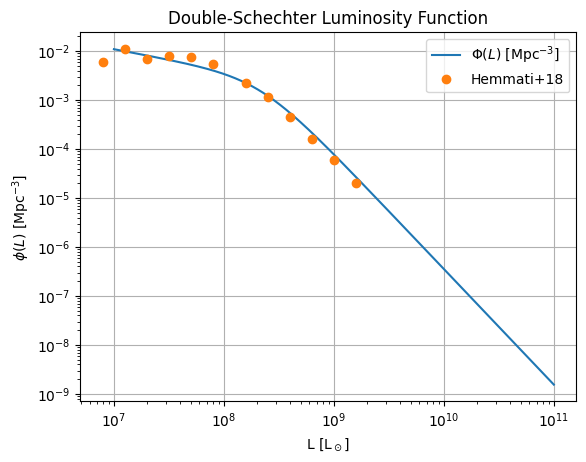

In [169]:
plt.loglog(Lgrid, phi_L, label = r'$\Phi(L)$ [Mpc$^{-3}$]')
plt.loglog(10**logL_vals, phi_vals, 'o', label='Hemmati+18')
plt.legend()
plt.xlabel(r'L [$\mathrm{L}_\odot$]')
plt.ylabel(r'$\phi(L)$ [$\mathrm{Mpc}^{-3}$]')
plt.title('Double-Schechter Luminosity Function')
plt.grid()

In [170]:
# map L -> I for each sub-survey
IList = [L_to_I(Lgrid, subSurv.zBin.zCenter, 
    delta_nu=subSurv.Instrument.dnu) for subSurv in TIMBins]

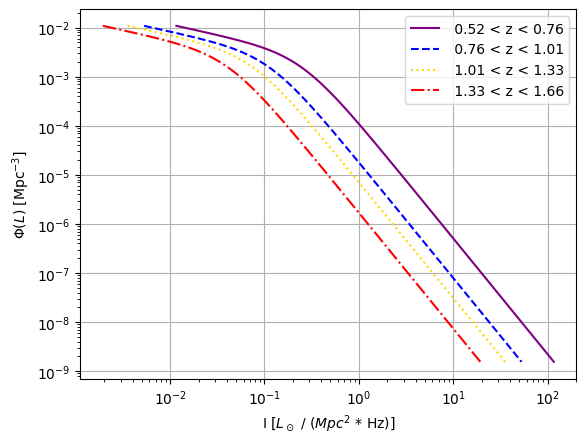

In [171]:
colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']
labels = [f" {subSurv.zBin.zFront:.2f} < z < {subSurv.zBin.zBack:.2f}" for subSurv in TIMBins]
[plt.loglog(Ivals, phi_L, color=color, linestyle=linestyle, label=label)
    for Ivals, color, linestyle, label in zip(IList, colors, linestyles, labels)]
plt.xlabel(r'I [$L_\odot$ / ($Mpc^2$ * Hz)]')
plt.ylabel(r'$\Phi(L)$ [Mpc$^{-3}$]')
plt.grid()
plt.legend()


In [180]:
def p1_I(LList, IList, phi_L, V_vox, Imin = 0, Imax = np.max(IList), nI = 20000):
    """Construct single-galaxy PDF p1(I) on a linear range of I.

    p1(I) = (V_vox * phi(L)) / Nbar * |dL/dI|
    but we construct the expected counts contribution per I-bin then normalize.
    """
    # map L -> I (this function assumes LList already mapped externally if needed)
    # user will pass LList already converted to I units

    Ireg = np.linspace(Imin, Imax, nI)
    dI = (Ireg[1] - Ireg[0]) 

# --- Ensure units are consistent if using astropy units ---
    if hasattr(IList, 'unit'):
        #print("Using astropy units...")
        Ireg = Ireg * IList.unit
        dI = dI * IList.unit
        Imin = Imin * IList.unit

    #p1_counts = np.zeros_like(Ireg)
    p1_counts = np.zeros(Ireg.shape)

    # bin contributions from LList -> Ireg
    # LList elements have implicit dL; approximate by differences
    dL = np.diff(LList)
    dL = np.append(dL, dL[-1])

    #print(f"IList Shape: {np.shape(IList)}, phi_L Shape: {np.shape(phi_L)}, dL Shape: {np.shape(dL)}")

    for Li, phiLi, dl in zip(IList, phi_L, dL):
        # Li now represents intensity value (I = conv*L) if LList was pre-converted
        #this makes the units wonky if using astropy units
        #TODO: I think phili needs to have units of number/volume/intensity
        # 
        idx = int(np.clip((Li - Imin) // dI, 0, len(Ireg)-1))
        num = ((V_vox * phiLi) * dl)
        #print(f"V_vox, {V_vox}, phiLi, {phiLi}, dl, {dl}, num, {num}")
        p1_counts[idx] += num #TODO: stopgap. fix units

    Nbar = np.sum(p1_counts)  # expected mean number of galaxies per voxel
    if Nbar <= 0:
        raise ValueError('Nbar <= 0, check phi_L or V_vox')

    # convert counts-per-bin -> PDF per unit intensity
    p1_I = p1_counts / (Nbar * dI)
    return Ireg, p1_I, Nbar

In [181]:
# build single-galaxy PDF p1(I)
Imin = 0.0
Imax = np.max(IList)* 3
nI = 2**13 # fine enough to avoid ringing in FFT  

PDTups = [p1_I(Lgrid, Is, phi_L, V_vox) for Is, V_vox in zip(IList, V_voxs)]
for Ireg, p1_I, Nbar in PDTups:
    print(f"Expected mean count per voxel Nbar = {Nbar}")
    print(f"p1_I sum check (should be 1): {np.sum(p1_I)*(Ireg[1]-Ireg[0])}")

Expected mean count per voxel Nbar = 15340393.861226877
p1_I sum check (should be 1): 1.0
Expected mean count per voxel Nbar = 38391242.86685324
p1_I sum check (should be 1): 0.9999999999999999
Expected mean count per voxel Nbar = 64289610.7589887
p1_I sum check (should be 1): 0.9999999999999999
Expected mean count per voxel Nbar = 130415283.10274449
p1_I sum check (should be 1): 1.0000000000000002


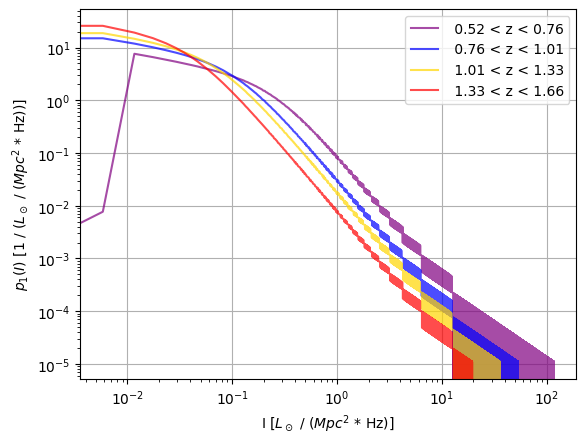

In [174]:
for i,(Ireg, p1_I, Nbar) in enumerate(PDTups):
    plt.loglog(Ireg, p1_I, label= labels[i], alpha = 0.7,
         color=colors[i])

plt.xlabel(r'I [$L_\odot$ / ($Mpc^2$ * Hz)]')
plt.ylabel(r'$p_1(I)$ [1 / ($L_\odot$ / ($Mpc^2$ * Hz))]')
plt.legend()
plt.grid()

In [198]:
[len(p1_I[p1_I==0])/len(p1_I) for (Ireg, p1_I, Nbar) in PDTups]


[0.6504, 0.7359, 0.7793, 0.8451]

In [202]:
# Smooth over zero-valued aspects of p1_I using a simple moving average filter

def smooth_zeros(Ireg, p1_I, window=5):
    """Replace zero-valued bins in p1_I with a moving average of neighbors."""
    import numpy as np
    from scipy.ndimage import uniform_filter1d

    # Only smooth where p1_I is zero
    mask = (p1_I == 0)
    # Apply moving average to the whole array
    smoothed = uniform_filter1d(p1_I, size=window, mode='nearest')*p1_I.unit
    # Replace zeros with the smoothed values
    #print(smoothed)
    #print(p1_I)
    p1_I_smooth = p1_I.copy()
    p1_I_smooth[mask] = smoothed[mask]
    return Ireg, p1_I_smooth

# Apply smoothing to all PDTups
PDTups_smoothed = [smooth_zeros(Ireg, p1_I) + (Nbar,) for (Ireg, p1_I, Nbar) in PDTups]

In [207]:
def smooth_p1(Ireg, p1_I, window=5, dip_thresh=0.1):
    """
    Replace zero-valued bins and bins with values much smaller than their neighbors
    in p1_I with a moving average of neighbors.
    dip_thresh: Fractional threshold; e.g., 0.1 means smooth if value < 10% of both neighbors.
    """
    import numpy as np
    from scipy.ndimage import uniform_filter1d

    p1_I = np.array(p1_I)
    # Mask for zeros
    mask_zero = (p1_I == 0)
    # Mask for dips: value much smaller than both immediate neighbors
    mask_dip = np.zeros_like(p1_I, dtype=bool)
    for i in range(1, len(p1_I)-1):
        left = p1_I[i-1]
        right = p1_I[i+1]
        if (p1_I[i] < dip_thresh * left) and (p1_I[i] < dip_thresh * right):
            mask_dip[i] = True
    # Combine masks
    mask = mask_zero | mask_dip
    # Moving average smoothing
    smoothed = uniform_filter1d(p1_I, size=window, mode='nearest')
    # Replace masked values with smoothed values
    p1_I_smooth = p1_I.copy()
    p1_I_smooth[mask] = smoothed[mask]
    return Ireg, p1_I_smooth

In [208]:
PDTups_smoothed = [smooth_p1(Ireg, p1_I) + (Nbar,) for (Ireg, p1_I, Nbar) in PDTups]

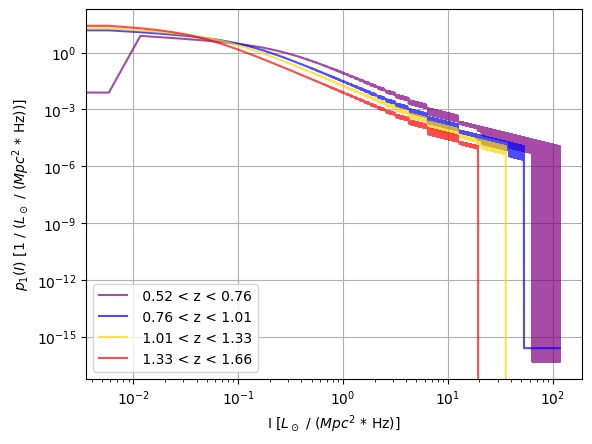

In [209]:
for i,(Ireg, p1_I, Nbar) in enumerate(PDTups_smoothed):
    plt.loglog(Ireg, p1_I, label= labels[i], alpha = 0.7,
         color=colors[i])

plt.xlabel(r'I [$L_\odot$ / ($Mpc^2$ * Hz)]')
plt.ylabel(r'$p_1(I)$ [1 / ($L_\odot$ / ($Mpc^2$ * Hz))]')
plt.legend()
plt.grid()

In [217]:
def p1_to_PI(Ireg, p1_I, Nbar):
    """Compute compound-Poisson total-intensity PDF P(I) from p1(I) using FFT.

    Uses characteristic function: P_hat(k) = exp[Nbar*(p1_hat(k)-1)].
    Numerically do discrete FFTs on a regularly spaced intensity grid.
    """
    dI = Ireg[1] - Ireg[0]
    # Fourier transform of p1 (use fft; treat p1 as sampled probability density)
    p1_hat = fft(p1_I) * dI
    P_hat = np.exp(Nbar * (p1_hat - 1.0))
    # inverse FFT
    P_I = np.real(ifft(P_hat)) / dI

    # align/shift so that I=0 corresponds to first element
    P_I = fftshift(P_I)
    Ireg_shifted = fftshift(Ireg - Ireg[0])

    # ensure positivity and renormalize
    P_I[P_I < 0] = 0.0
    norm = np.sum(P_I) * dI
    if norm > 0:
        P_I = P_I / norm

    return Ireg_shifted, P_I

In [210]:
def p1_to_PI(Ireg, p1_I, Nbar):
    """
    Compute compound-Poisson total-intensity PDF P(I) from p1(I) using FFT.

    Handles zero values and discontinuities in p1_I that can generate NaNs or infs in the FFT.
    """
    import numpy as np
    from scipy.fft import fft, ifft, fftshift

    dI = Ireg[1] - Ireg[0]

    # Replace NaNs, infs, and negative values in p1_I with zero
    p1_I_clean = np.array(p1_I)
    p1_I_clean[~np.isfinite(p1_I_clean)] = 0.0
    p1_I_clean[p1_I_clean < 0] = 0.0

    # Optionally smooth over zeros and sharp dips (reuse your smooth_p1 function if desired)
    # Ireg, p1_I_clean = smooth_p1(Ireg, p1_I_clean, window=5, dip_thresh=0.1)

    # Ensure normalization
    norm = np.sum(p1_I_clean) * dI
    if norm > 0:
        p1_I_clean = p1_I_clean / norm

    # Fourier transform of p1 (use fft; treat p1 as sampled probability density)
    p1_hat = fft(p1_I_clean) * dI
    # Remove any remaining NaNs/infs in p1_hat
    p1_hat[~np.isfinite(p1_hat)] = 0.0

    P_hat = np.exp(Nbar * (p1_hat - 1.0))
    # Remove any NaNs/infs in P_hat
    P_hat[~np.isfinite(P_hat)] = 0.0

    # inverse FFT
    P_I = np.real(ifft(P_hat)) / dI

    # align/shift so that I=0 corresponds to first element
    P_I = fftshift(P_I)
    Ireg_shifted = fftshift(Ireg - Ireg[0])

    # ensure positivity and renormalize
    P_I[P_I < 0] = 0.0
    norm = np.sum(P_I) * dI
    if norm > 0:
        P_I = P_I / norm

    return Ireg_shifted, P_I

In [218]:
P_ITups = [p1_to_PI(Ireg.value, p1_I.value, Nbar)
            for Ireg, p1_I, Nbar in PDTups]

IregShifts, P_Is = zip(*P_ITups) 

In [219]:
P_Is

(array([0.00857349, 0.00857349, 0.00857349, ..., 0.00857349, 0.00857349,
        0.00857349]),
 array([0.00857349, 0.00857349, 0.00857349, ..., 0.00857349, 0.00857349,
        0.00857349]),
 array([0.00857349, 0.00857349, 0.00857349, ..., 0.00857349, 0.00857349,
        0.00857349]),
 array([0.00857349, 0.00857349, 0.00857349, ..., 0.00857349, 0.00857349,
        0.00857349]))

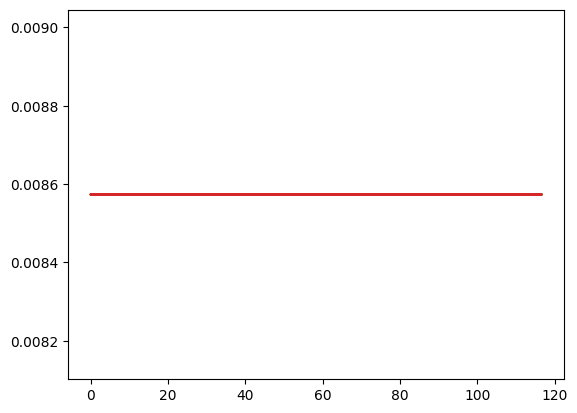

In [220]:
test = P_ITups[0]
test2 = P_ITups[1]
test3 = P_ITups[2]
test4 = P_ITups[3]

plt.plot(test[0], test[1])
plt.plot(test[0], test2[1])
plt.plot(test[0], test3[1])
plt.plot(test[0], test4[1])

In [ ]:
test4

[[<matplotlib.lines.Line2D at 0x1e4b75ae7c0>],

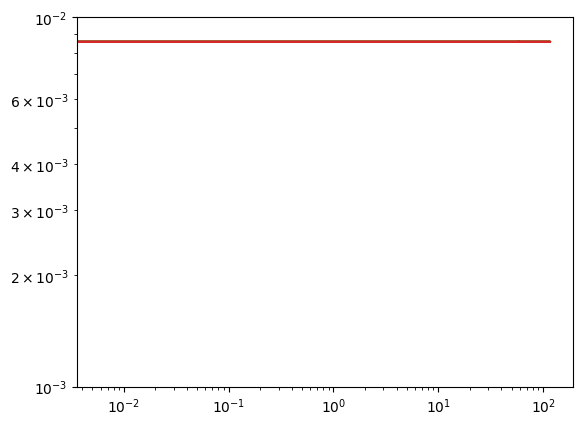

In [179]:
[plt.loglog(Ireg_shifted, P_I) for Ireg_shifted, P_I in P_ITups]

In [ ]:
P_I_noisy = [convolve_with_gaussian(Ireg_shifted, P_I, noise.value)
                                    for (Ireg_shifted, P_I), noise in zip(P_ITups, TIMNoise)]

    # define bins (log-spaced) for VID histogram
nbins = 40
bin_edges = [np.logspace(np.log10(max(1e-10, Ireg_shifted[1])), np.log10(Ireg_shifted.max()), nbins+1) 
                for Ireg_shifted, P_I in P_ITups]


In [ ]:
[plt.loglog(Ireg_shifted, P_I_noisy_i) for (Ireg_shifted, _), P_I_noisy_i in zip(P_ITups, P_I_noisy)]

In [ ]:
# build lambda_b function closure
def build_lambda_b(local_params):
    # rebuild phi_L for modified params
    phi_L_local = schechter_L(Lgrid, local_params['phi_star'], local_params['L_star'], local_params['alpha'])
    # rebuild p1 using same I_fromL grid
    Ireg_loc, p1_I_loc, Nbar_loc = build_p1_I(I_fromL, phi_L_local, V_vox, Imin, Imax, nI)
    Ireg_loc_s, P_I_loc = compound_poisson_pdf_from_p1(Ireg_loc, p1_I_loc, Nbar_loc)
    P_I_loc_noisy = convolve_with_gaussian(Ireg_loc_s, P_I_loc, sigma_noise)
    lambda_b = compute_binned_counts(Ireg_loc_s, P_I_loc_noisy, Nvox, bin_edges)
    return lambda_b

In [ ]:

# numerical derivatives and fisher
param_keys = ['phi_star', 'L_star', 'alpha']
base_lambda, dlam = numeric_derivatives(params, param_keys, build_lambda_b, eps_frac=1e-2)
F = fisher_from_binned_counts(base_lambda, dlam)

# invert fisher safely (regularize tiny eigenvalues)
try:
    cov = np.linalg.inv(F)
except np.linalg.LinAlgError:
    # add a small diagonal regularization
    reg = 1e-12 * np.eye(F.shape[0])
    cov = np.linalg.inv(F + reg)

errs = np.sqrt(np.diag(cov))

In [ ]:
# -----------------------------
# 9) Example: put it all together
# -----------------------------

def example_run():
    # --- fiducial Schechter parameters (toy values) ---
    params = {
        'phi_star': 1e-3,
        'L_star': 1.0,
        'alpha': -1.3
    }

    # survey/instrument specs (toy)
    z = 6.0
    V_vox = 1e3        # comoving voxel volume (arbitrary units)
    Nvox = int(1e5)    # number of independent voxels in survey
    sigma_noise = 5e-4 # noise rms in intensity units (same units as I)

    # L grid (in 'intensity' units after conversion L->I); here we'll treat Lgrid as L but
    # use L_to_I as simple linear conv. For real use, compute proper conversion per L.
    Lmin, Lmax = 1e-4, 50.0
    nL = 2000
    Lgrid = np.logspace(np.log10(Lmin), np.log10(Lmax), nL)
    phi_L = schechter_L(Lgrid, params['phi_star'], params['L_star'], params['alpha'])

    # map L -> I (simple linear conv inside L_to_I)
    I_fromL = L_to_I(Lgrid, z, delta_nu=1.0)

    # build single-galaxy PDF p1(I)
    Imin, Imax = 0.0, float(I_fromL.max() * 3.0)
    nI = 2**13
    Ireg, p1_I, Nbar = build_p1_I(I_fromL, phi_L, V_vox, Imin, Imax, nI)
    print(f"Expected mean count per voxel Nbar = {Nbar:.4f}")

    # compound Poisson -> total intensity PDF
    Ireg_shifted, P_I = compound_poisson_pdf_from_p1(Ireg, p1_I, Nbar)

    # convolve with noise
    P_I_noisy = convolve_with_gaussian(Ireg_shifted, P_I, sigma_noise)

    # define bins (log-spaced) for VID histogram
    nbins = 40
    bin_edges = np.logspace(np.log10(max(1e-10, Ireg_shifted[1])), np.log10(Ireg_shifted.max()), nbins+1)

    # build lambda_b function closure
    def build_lambda_b(local_params):
        # rebuild phi_L for modified params
        phi_L_local = schechter_L(Lgrid, local_params['phi_star'], local_params['L_star'], local_params['alpha'])
        # rebuild p1 using same I_fromL grid
        Ireg_loc, p1_I_loc, Nbar_loc = build_p1_I(I_fromL, phi_L_local, V_vox, Imin, Imax, nI)
        Ireg_loc_s, P_I_loc = compound_poisson_pdf_from_p1(Ireg_loc, p1_I_loc, Nbar_loc)
        P_I_loc_noisy = convolve_with_gaussian(Ireg_loc_s, P_I_loc, sigma_noise)
        lambda_b = compute_binned_counts(Ireg_loc_s, P_I_loc_noisy, Nvox, bin_edges)
        return lambda_b



In [ ]:

    # numerical derivatives and fisher
    param_keys = ['phi_star', 'L_star', 'alpha']
    base_lambda, dlam = numeric_derivatives(params, param_keys, build_lambda_b, eps_frac=1e-2)
    F = fisher_from_binned_counts(base_lambda, dlam)

    # invert fisher safely (regularize tiny eigenvalues)
    try:
        cov = np.linalg.inv(F)
    except np.linalg.LinAlgError:
        # add a small diagonal regularization
        reg = 1e-12 * np.eye(F.shape[0])
        cov = np.linalg.inv(F + reg)

    errs = np.sqrt(np.diag(cov))

    print('\nFiducial parameters:')
    for k in param_keys:
        print(f"  {k} = {params[k]}")
    print('\nForecast 1-sigma errors (Fisher approx):')
    for k, e in zip(param_keys, errs):
        print(f"  sigma({k}) = {e:.3e}")

    # plot VID and binned expectations
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(Ireg_shifted, P_I, label='P(I) (no noise)')
    axs[0].plot(Ireg_shifted, P_I_noisy, label='P(I) (with noise)')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Intensity (I)')
    axs[0].set_ylabel('PDF')
    axs[0].legend()

    # bar plot of expected counts per bin
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    axs[1].bar(bin_centers, base_lambda, width=bin_edges[1:]-bin_edges[:-1])
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Intensity bin center')
    axs[1].set_ylabel('Expected voxel counts')
    plt.tight_layout()
    plt.show()

    return {
        'params': params,
        'Ireg': Ireg_shifted,
        'P_I': P_I,
        'P_I_noisy': P_I_noisy,
        'bin_edges': bin_edges,
        'lambda_b': base_lambda,
        'Fisher': F,
        'cov': cov
    }

# -----------------------------
# Run example when executed
# -----------------------------
if __name__ == '__main__':
    results = example_run()
    # save results optionally
    # np.savez('vid_forecast_results.npz', **results)

# End of template